In [1]:
import sys, pickle
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse

In [16]:
def get_T(seq, temp, nstates):
    '''get transition matrix from sequence'''

    meta_dir = f'../MSM_construction/MSMs/{seq}_dist_reduced_{temp}K_40-250000-55_micro-200_macro-{nstates}_lag-12_srvlag-12/' #
    msm_hde = pickle.load(open(meta_dir + 'msm_hde.pkl', 'rb'))
    pcca = msm_hde.pcca(nstates)
    
    T = pcca.coarse_grained_transition_matrix.copy()
    T[T < 0] *= 0
    T = T/T.sum(axis=1)[:, np.newaxis]
    return msm_hde, T

param_dict = {'AT-all':(309, 6, 5, 4), 
              'GC-end':(317, 5, 3, 4), 
              'GC-core':(324, 3, 2, 1),
              'GC-mix':(324, 2, 1, 0)}

states_dict = {'AT-all':['3S4', '5S4', '3S2', '5S2', 'H', 'D'], 
               'GC-end':['5S4', '3S2', '5S2', 'D', 'H'],
               'GC-core':['F4', 'H', 'D'], 
               'GC-mix':['H', 'D']}

# sequence specific info
seq = 'GC-end'
temp, nstates, s0, sf = param_dict[seq]

msm, T = get_T(seq, temp, nstates)
print(T)

[[6.63909071e-01 2.83175725e-04 6.21374527e-03 3.17491220e-01
  1.21027877e-02]
 [9.63002208e-05 9.07910705e-01 4.87693415e-04 4.34204812e-02
  4.80848197e-02]
 [4.58839506e-04 1.75643939e-04 9.62252790e-01 1.78839595e-02
  1.92287672e-02]
 [1.36907710e-04 5.45197047e-05 5.70757643e-05 9.99317891e-01
  4.33605561e-04]
 [2.84494884e-06 3.70249339e-05 4.36820697e-05 3.29438789e-04
  9.99587009e-01]]


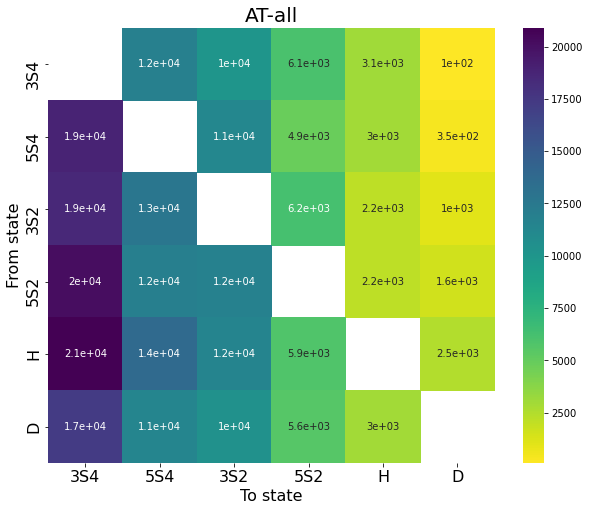

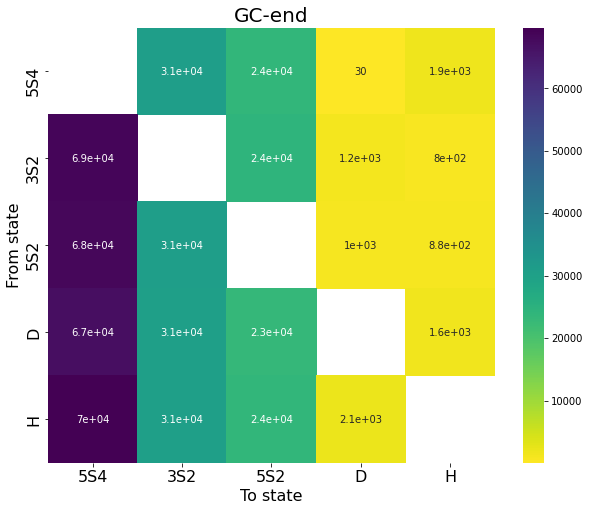

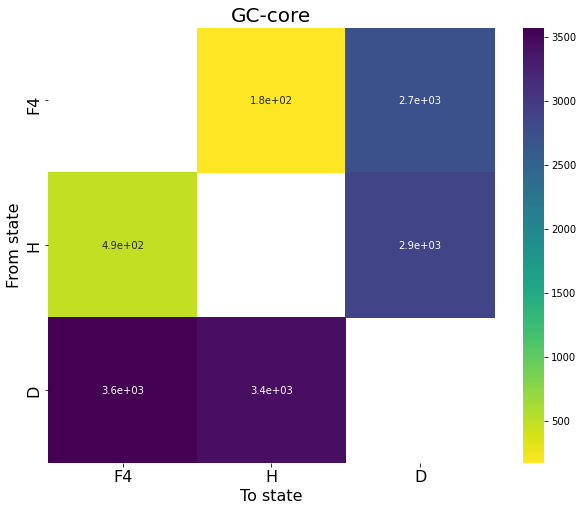

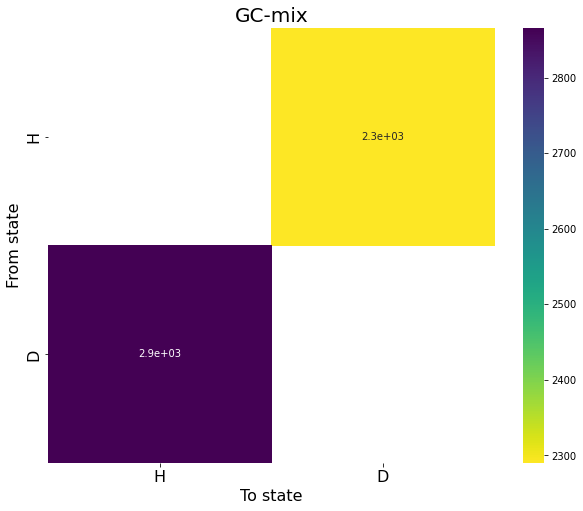

In [22]:
# try using built-in tpt function in pyemma
# mfpt returns the mean-first-passage-time (inverse rate) of A–>B transitions

ts = 0.1 # ns

seq_list = ['AT-all', 'GC-end', 'GC-core', 'GC-mix']
for seq in seq_list:

    temp, nstates, s0, sf = param_dict[seq]
    #nstates = 2 # just build two-state for each sequence
    msm, T = get_T(seq, temp, nstates)
    ticks = states_dict[seq]

    tpt_arr = np.zeros((nstates, nstates))
    tpt_mask = np.zeros((nstates, nstates))
    state_list = np.arange(nstates)
    for A in state_list:
        for B in state_list:
            if A != B:
                A_micros = msm.metastable_sets[A]
                B_micros = msm.metastable_sets[B]
                tpt = pyemma.msm.tpt(msm, A_micros, B_micros)
                tpt_arr[A, B] = tpt.mfpt*ts
            else:
                tpt_mask[A, B] = 1

    # show mfpt as heatmap between states
    fig, axes = plt.subplots(figsize=(10, 8))
    sns.heatmap(tpt_arr, ax=axes, cmap='viridis_r', annot=True, mask=tpt_mask)
    axes.set_xlabel('To state', fontsize=16)
    axes.set_ylabel('From state', fontsize=16)
    axes.set_xticklabels(ticks, fontsize=16)
    axes.set_yticklabels(ticks, fontsize=16)
    axes.set_title(seq, fontsize=20)

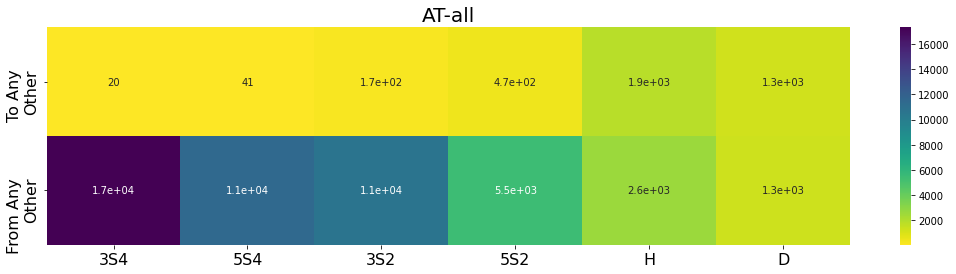

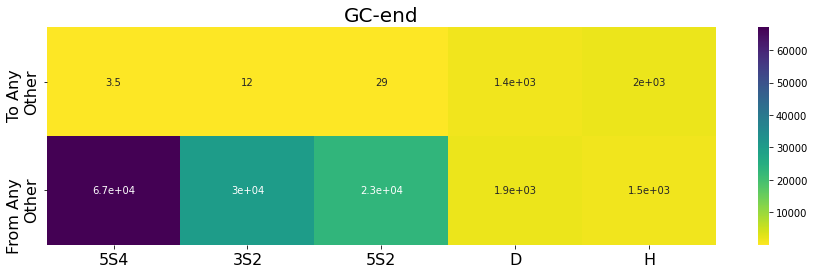

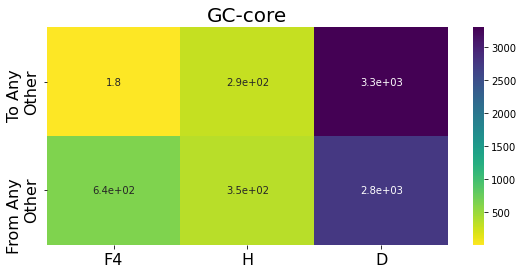

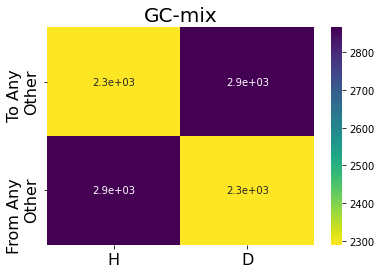

In [30]:
# now consider mfpt moving from a given macrostate to any other macrostate

# try using built-in tpt function in pyemma
# mfpt returns the mean-first-passage-time (inverse rate) of A–>B transitions

tpt_list = []
for seq in seq_list:

    temp, nstates, s0, sf = param_dict[seq]
    msm, T = get_T(seq, temp, nstates)

    tpt_arr = np.zeros((2, nstates))
    state_list = np.arange(nstates)
    ticks = states_dict[seq]
    
    for A in state_list:
        A_micros = msm.metastable_sets[A]
        B_micros = []
        for B in state_list:
            if A != B:
                B_micros += list(msm.metastable_sets[B])
        tpt_AB = pyemma.msm.tpt(msm, A_micros, B_micros)
        tpt_BA = pyemma.msm.tpt(msm, B_micros, A_micros)
        tpt_arr[0, A] = tpt_AB.mfpt*ts
        tpt_arr[1, A] = tpt_BA.mfpt*ts
    tpt_list.append(tpt_arr)

    # show mfpt as heatmap between states
    fig, axes = plt.subplots(figsize=(3*nstates, 4))
    sns.heatmap(tpt_arr, ax=axes, cmap='viridis_r', annot=True)
    #axes.set_xlabel('To state', fontsize=16)
    #axes.set_ylabel('From state', fontsize=16)
    axes.set_xticklabels(ticks, fontsize=16)
    axes.set_yticklabels(['To Any\nOther', 'From Any\nOther'], fontsize=16)
    axes.set_title(seq, fontsize=20)

AT-all [  20.43158866   40.91589208  165.82083084  470.70462993 1856.73475933
 1254.36007135]
GC-end [   3.54098367   12.10882258   29.12372195 1400.64493061 1987.47790365]
GC-core [1.78285422e+00 2.90826521e+02 3.29772098e+03]
GC-mix [2290.06823065 2865.66964193]


No handles with labels found to put in legend.


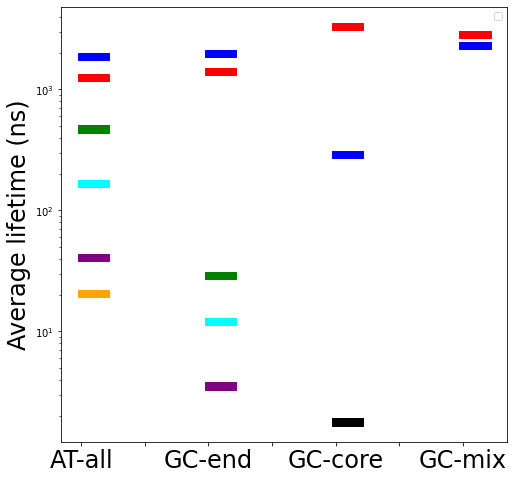

In [39]:
## plot timescales seperately
fig, axes = plt.subplots(figsize=(8, 8) )
color_dict = {'H':'blue', 'D':'red', '5S2':'green', '3S2':'cyan', 
              '5S4':'purple', '3S4':'orange', 'F4':'black'}
thickness, dt = 20, .01

for i, (seq, tpt_arr) in enumerate(zip(seq_list, tpt_list)):

    print(seq, tpt_arr[0])
    state_list = states_dict[seq]
    color_list = [color_dict[state] for state in state_list]
    for t in range(thickness):
        axes.scatter(np.zeros(len(tpt_arr[0]))+i+t*dt, tpt_arr[0], marker="s", 
                     c=color_list, s=50)
        
        #axes.errorbar(np.zeros(len(ts_mean))+i+t*dt, ts_mean, yerr=ts_std, 
                     #c=color_list[:len(ts_mean)], linestyle="None", color='black', capsize=2)

labels = [item.get_text() for item in axes.get_xticklabels()]
for i in range(len(seq_list)):
    labels[i*2+1] = seq_list[i]

axes.set_xticklabels(labels, fontsize=24)
axes.set_ylabel('Average lifetime (ns)', fontsize=24)
axes.legend()
            
#axes.set_xticks(seq_list)
#axes.set_xticklabels(seq_list, {'horizontalalignment': 'center'})
axes.set_yscale('log')

In [128]:
# Use TPT to determine H <--> D pathways and intermediates

def find_path_contributions(msm, A, B):
    '''Contributions along each path from A --> B'''

    # seperates 200 microstates into source (A), target (B), intermediates (C)
    tpt = pyemma.msm.tpt(msm, A, B)

    # coarse grain into pcca states
    sets, tpt = tpt.coarse_grain(msm.metastable_sets)

    # reorder set to fit tick labels
    sets_reorder = {}
    for i_tpt, s_tpt in enumerate(sets):
        for i_msm, s_msm in enumerate(msm.metastable_sets):
            if s_tpt[0] in s_msm:
                sets_reorder[i_tpt] = i_msm

    # calculate all possible paths between H <--> D using coarse-grained sets
    paths, capacities = tpt.pathways()

    # find each path contribution out of total
    c_sum = np.sum(capacities)
    for p, c in zip(paths, capacities):
        state_sequence = [ticks[sets_reorder[s]] for s in p]
        c_fraction = np.around(100*c/c_sum, 1)
        if c_fraction > 0.01: print(state_sequence, c_fraction, '%')
        
D_micros = msm.metastable_sets[ticks.index('D')]
H_micros = msm.metastable_sets[ticks.index('H')]

print(seq, '\n')
find_path_contributions(msm, H_micros, D_micros)
print('\n')
find_path_contributions(msm, D_micros, H_micros)

GC-end 

['H', 'D'] 93.0 %
['H', '5S2', 'D'] 3.9 %
['H', '3S2', 'D'] 3.0 %


['D', 'H'] 93.0 %
['D', '5S2', 'H'] 3.9 %
['D', '3S2', 'H'] 3.0 %


In [129]:
## look for partial events that do not proceed to full hybridization
# Use TPT to determine H <--> D pathways and intermediates

def find_path_contributions(msm, A, B):
    '''Contributions along each path from A --> B'''

    # seperates 200 microstates into source (A), target (B), intermediates (C)
    tpt = pyemma.msm.tpt(msm, A, B)

    # coarse grain into pcca states
    sets, tpt = tpt.coarse_grain(msm.metastable_sets)

    # reorder set to fit tick labels
    sets_reorder = {}
    for i_tpt, s_tpt in enumerate(sets):
        for i_msm, s_msm in enumerate(msm.metastable_sets):
            if s_tpt[0] in s_msm:
                sets_reorder[i_tpt] = i_msm

    # calculate all possible paths between H <--> D using coarse-grained sets
    paths, capacities = tpt.pathways()

    # find each path contribution out of total
    c_sum = np.sum(capacities)
    for p, c in zip(paths, capacities):
        state_sequence = [ticks[sets_reorder[s]] for s in p]
        c_fraction = np.around(100*c/c_sum, 1)
        if c_fraction > 0.01: print(state_sequence, c_fraction, '%')
    
n_micros = 200
D_micros = msm.metastable_sets[ticks.index('D')]
H_micros = msm.metastable_sets[ticks.index('H')]
not_D_micros = [i for i in range(n_micros ) if i not in D_micros] # all states not D

print('\n', seq, '\n')
find_path_contributions(msm, D_micros, not_D_micros)

# find probability of every other state to H
for i, s in enumerate(ticks[:-2]):
    s_micros = msm.metastable_sets[i]
    print('\n', s, '\n')
    find_path_contributions(msm, s_micros, H_micros)


 GC-end 

['D', 'H'] 82.4 %
['D', '5S2'] 7.9 %
['D', '3S2'] 5.0 %
['D', '5S4'] 4.8 %

 5S4 

['5S4', 'D', 'H'] 91.8 %
['5S4', 'D', '3S2', 'H'] 3.1 %
['5S4', 'D', '5S2', 'H'] 2.9 %
['5S4', '5S2', 'H'] 1.5 %
['5S4', 'H'] 0.6 %

 3S2 

['3S2', 'H'] 56.2 %
['3S2', 'D', 'H'] 42.2 %
['3S2', 'D', '5S2', 'H'] 1.5 %
['3S2', '5S2', 'H'] 0.1 %

 5S2 

['5S2', 'D', 'H'] 51.2 %
['5S2', 'H'] 47.2 %
['5S2', 'D', '3S2', 'H'] 0.9 %
['5S2', '5S4', 'D', '3S2', 'H'] 0.5 %
['5S2', '3S2', 'H'] 0.1 %


In [130]:
## now look at transitions from hybridized state to any other state

def find_path_contributions(msm, A, B):
    '''Contributions along each path from A --> B'''

    # seperates 200 microstates into source (A), target (B), intermediates (C)
    tpt = pyemma.msm.tpt(msm, A, B)

    # coarse grain into pcca states
    sets, tpt = tpt.coarse_grain(msm.metastable_sets)

    # reorder set to fit tick labels
    sets_reorder = {}
    for i_tpt, s_tpt in enumerate(sets):
        for i_msm, s_msm in enumerate(msm.metastable_sets):
            if s_tpt[0] in s_msm:
                sets_reorder[i_tpt] = i_msm

    # calculate all possible paths between H <--> D using coarse-grained sets
    paths, capacities = tpt.pathways()

    # find each path contribution out of total
    c_sum = np.sum(capacities)
    for p, c in zip(paths, capacities):
        state_sequence = [ticks[sets_reorder[s]] for s in p]
        c_fraction = np.around(100*c/c_sum, 1)
        if c_fraction > 0.01: print(state_sequence, c_fraction, '%')
    
n_micros = 200
D_micros = msm.metastable_sets[ticks.index('D')]
H_micros = msm.metastable_sets[ticks.index('H')]
not_H_micros = [i for i in range(n_micros ) if i not in H_micros] # all states not D

print('\n', seq, '\n')
find_path_contributions(msm, H_micros, not_H_micros)

# find probability of every other state to H
for i, s in enumerate(ticks[:-2]):
    s_micros = msm.metastable_sets[i]
    print('\n', s, '\n')
    find_path_contributions(msm, s_micros, D_micros)


 GC-end 

['H', 'D'] 87.1 %
['H', '5S2'] 6.6 %
['H', '3S2'] 6.2 %

 5S4 

['5S4', 'D'] 98.0 %
['5S4', '5S2', 'D'] 0.9 %
['5S4', '5S2', 'H', 'D'] 0.6 %
['5S4', 'H', 'D'] 0.5 %

 3S2 

['3S2', 'H', 'D'] 50.1 %
['3S2', 'D'] 47.8 %
['3S2', 'H', '5S2', 'D'] 2.0 %
['3S2', '5S2', 'D'] 0.1 %

 5S2 

['5S2', 'D'] 58.0 %
['5S2', 'H', 'D'] 40.1 %
['5S2', 'H', '3S2', 'D'] 1.2 %
['5S2', '5S4', 'D'] 0.5 %
['5S2', '3S2', 'D'] 0.1 %


[0 1 2 3 4]
[ 190.  117.  115. 1000. 1000.]
[0.012 0.063 0.066 0.    1.   ] 0.138


<BarContainer object of 5 artists>

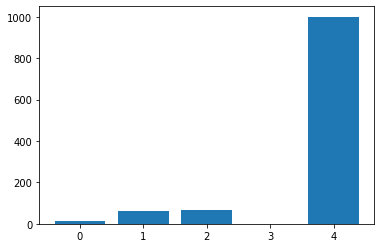

In [131]:
# perform path contributions by hand

nevents = 1000
nchunks = 10

# switch initial and final to model dissociation
reverse=False
if reverse:
    tp = s0
    s0 = sf
    sf = tp

all_s = np.arange(0, nstates, 1, dtype=int)
print(all_s)

s_visits = np.zeros(nstates)
s_last = np.zeros(nstates)
n_multi = 0

for i in range(nevents):
    
    # keep track of path to sf
    s_list = []
    s = s0
    
    # simulate until final state is reached
    while s != sf:
        
        # weight probabilities according to transition matrix
        p = T[s]
        s = np.random.choice(all_s, p=p)
        s_list.append(str(s))
        
    # check the immediate transition only (does not look at redissociation pathways)
    s_joined = ''.join(s_list)
    last_hybrid = s_joined.split(str(s0))[-1]
    if len(last_hybrid) > 1: n_multi +=  1
        
    # check if each states was visited over the course simulation
    for s in all_s:
        if str(s) in s_list:
            s_visits[s] +=1 
        
        if str(s) in last_hybrid:
            s_last[s] += 1
    
print(s_visits)
s_last = np.array(s_last)
print(np.round(np.array(s_last)/nevents, 3), n_multi/nevents)

plt.bar(all_s, s_last)